<a href="https://colab.research.google.com/github/Jaehwi-So/DeepLearning_Study/blob/main/DL10_VAE_and_Autoencoderipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 시각화를 위한 코드

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Visualization function
def plot_latent_space(vae, n=15, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.get_layer("decoder").predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

# 데이터 로드 및 전처리
MNIST 숫자 데이터를 사용하여 이를 인코딩한 후 복원하는 과정을 살펴본다.

In [8]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data() # y를 사용하지 않음
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [9]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

# 1. Autoencoder 모델 정의

In [6]:
# 입력 데이터 차원
input_dim = 28*28  # 28x28 픽셀 이미지가 1차원 벡터로 변환된 형태
encoding_dim = 32  # 잠재 공간의 차원 -> 늘릴 수록 표현이 잘 됨

In [7]:
# 인코더 정의
encoder = Sequential([
    Flatten(input_shape=(28, 28)),  # 입력 이미지를 1차원 벡터로 변환
    Dense(encoding_dim, activation='relu') # 인코딩 레이어
])

# 디코더 정의
decoder = Sequential([
    Dense(input_dim, activation='sigmoid', input_shape=(encoding_dim,)), # 디코딩 레이어
    Reshape((28, 28))  # 1차원 벡터를 다시 28x28 이미지로 변환
])

# 오토인코더 모델 정의
autoencoder = Sequential([encoder, decoder])

# 손실 함수로 binary_crossentropy 사용
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 훈련

In [10]:
autoencoder.fit(
                x_train, x_train, # X값으로만 학습을 진행
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0,
                validation_data=(
                    x_test, x_test
                ))

# 재구성된 데이터 확인
- Autoencoder에 의해서 Latent Space로부터 다시 복원된 데이터를 확인해보자.

In [11]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 3ms/step


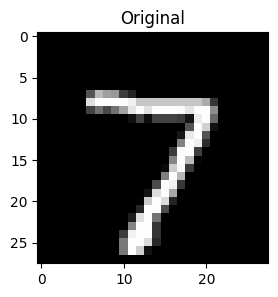

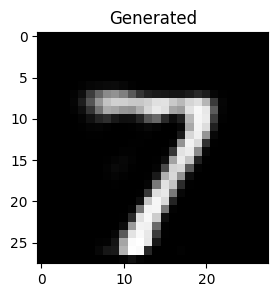

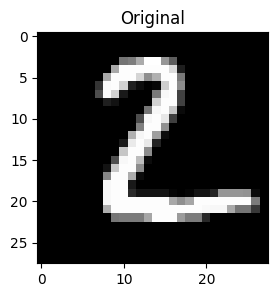

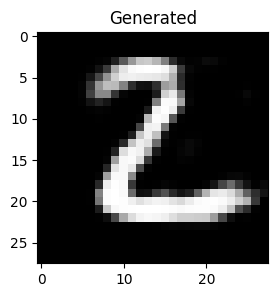

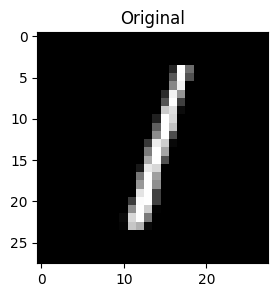

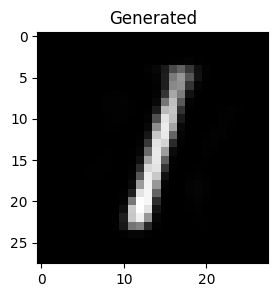

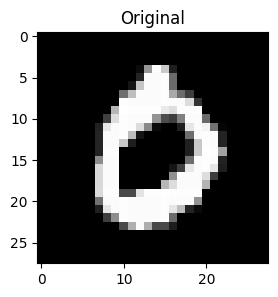

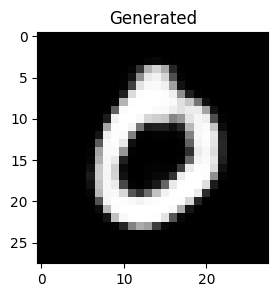

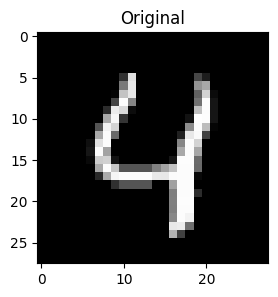

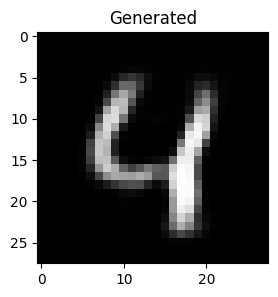

In [13]:
for i in range(5): #5개 확인
  # 원본 이미지
  plt.figure(figsize=(3,3))
  plt.title("Original")
  plt.imshow(x_test[i], cmap='gray')
  plt.show()
  # 재구성된 이미지
  plt.figure(figsize=(3,3))
  plt.title("Generated")
  plt.imshow(decoded_imgs[i], cmap='gray')
  plt.show()

# 2. VAE 모델 정의

In [16]:
latent_dim = 2

# 인코더 정의
encoder = Sequential([
    Input(shape=(28, 28)),  # 입력 이미지 크기
    Flatten(),  # 입력 이미지를 1차원 벡터로 변환
    Dense(128, activation='relu'), # 중간 레이어
    Dense(latent_dim + latent_dim) # z_mean과 z_log_var를 함께 출력
], name='encoder')
encoder.summary()


# 샘플링 레이어를 정의
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = tf.split(inputs, num_or_size_splits=2, axis=1)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# 디코더 정의
decoder = Sequential([
    Input(shape=(latent_dim,)),  # 잠재 공간 입력
    Dense(128, activation='relu'),  # 중간 레이어
    Dense(28 * 28, activation='sigmoid'), # 출력 레이어
    Reshape((28, 28))  # 1차원 벡터를 다시 28x28 이미지로 변환
], name='decoder')
decoder.summary()

# VAE 모델 정의
vae = Sequential([encoder, Sampling(), decoder], name='vae')

# 손실 함수 정의 (reconstruction_loss + kl_loss)
def vae_loss(inputs, outputs, z_mean_log_var):
    z_mean, z_log_var = tf.split(z_mean_log_var, num_or_size_splits=2, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, outputs)) * 28 * 28
    kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    return reconstruction_loss + kl_loss

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
vae.compile(optimizer, loss=lambda inputs, outputs: vae_loss(inputs, outputs, encoder(inputs)))

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 100996 (394.52 KB)
Trainable params: 100996 (394.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               384       
                                                                 
 d

# 모델 훈련

In [17]:
# 모델 학습
vae.fit(
        x_train, x_train, #모델 입력/출력 (입력 데이터가 얼마나 유지된 채로 나오는 지 학습)
        epochs=30, batch_size=128,
        verbose=0,
        validation_data=(
            x_test, x_test
))

# 결과 확인
- Latent Space의 확률 분포에 따라 어떻게 이미지가 변화하는지 확인

1/1 [==============================] - 0s 25ms/step


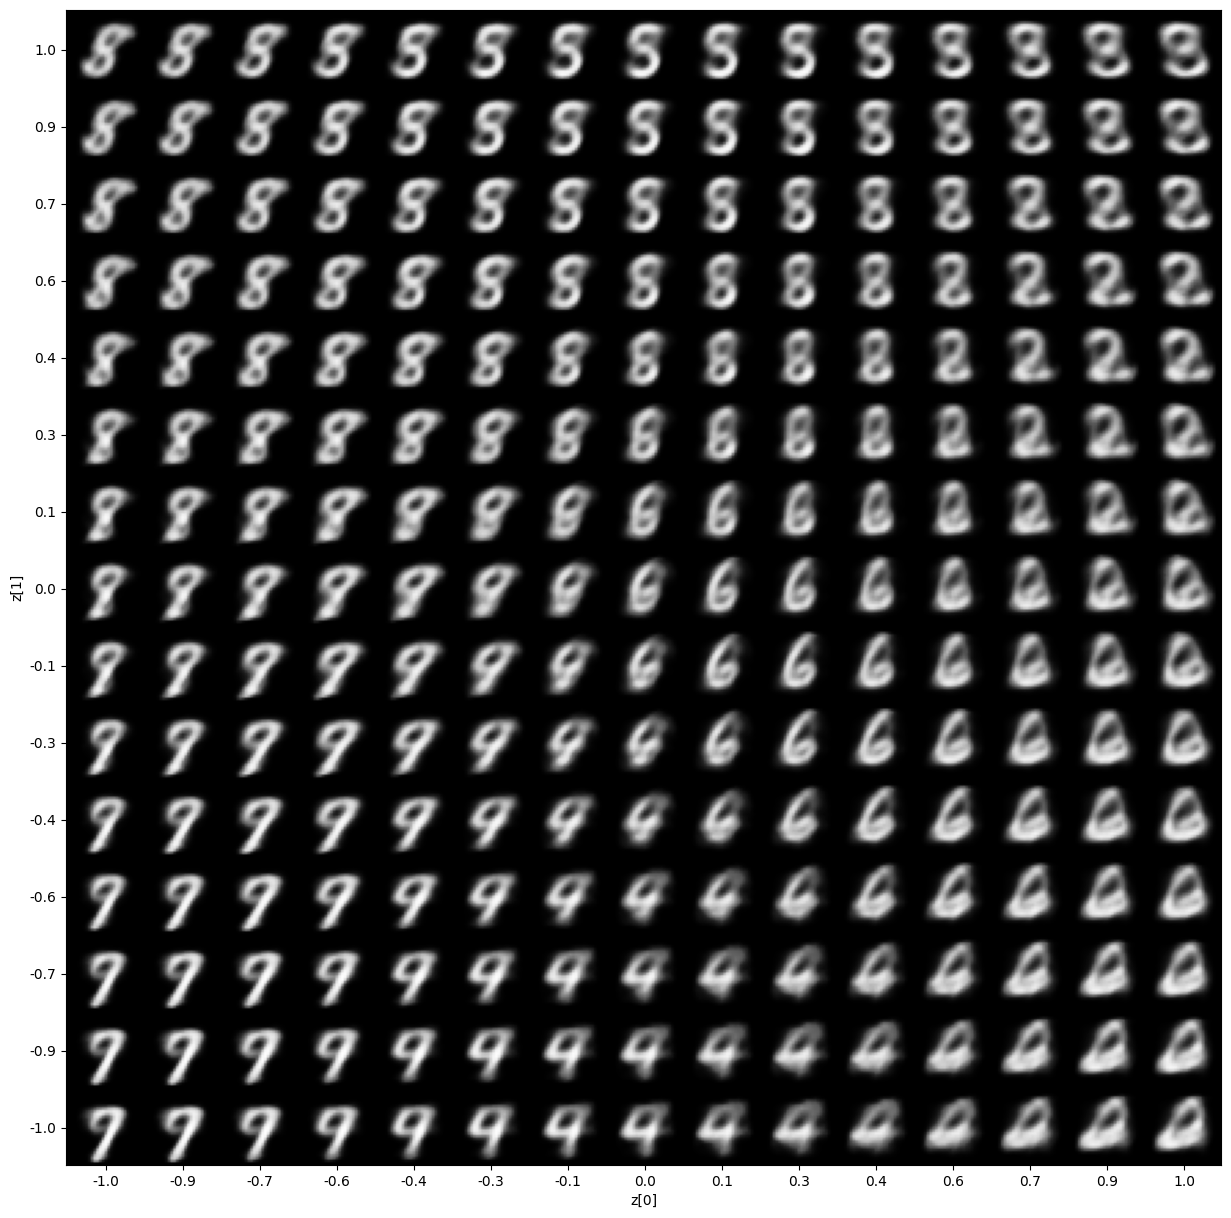

In [18]:
plot_latent_space(vae)